In [1]:
import CUDA
using Knet
using CUDA: CUDA, CuArray
using Images
using ImageMagick
using Random
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using IterTools: ncycle, takenth

In [2]:
Random.seed!(123);

In [3]:
bs = 64;
resolution = 16; #16 for Baseline
decoder_res = 2
slot_size = 32;
num_slots = 4;
num_iterations = 3;
hidden_dim = 32;

In [4]:
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
atype() = array_type
atype(x) = convert(atype(),x)

function load_image(filename)
    img = load(filename)
    img = imresize(img, (resolution,resolution))
    img = Float64.(channelview(img))
    img = img[1:3,:,:]
    img = permutedims(img, [2, 3, 1])
    img = img .* 2 .- 1
end

struct CLEVR
    images
    batchsize::Int
    num_instances::Int
    shuffle::Bool
    function CLEVR(datasetPaths; batchsize::Int=32, shuffle::Bool=false)
        nFullBatches, rem = divrem(size(datasetPaths)[end], batchsize)
        new(datasetPaths[1:nFullBatches*batchsize], batchsize, nFullBatches*batchsize, shuffle)
    end
end

function length(d::CLEVR)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

function iterate(d::CLEVR, state=ifelse(d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    if length(state) > 0
        imgBatch = load_image.(d.images[state[1:(length(state) < d.batchsize ? end : d.batchsize)]])
        batch = cat(imgBatch..., dims = 4)
        state  = state[d.batchsize+1:end]
        return atype(batch), state
    end
end

iterate (generic function with 435 methods)

In [5]:
trainDataPath = "//userfiles//ashah20//datasets//tetrominoes//train//images"
files = readdir(trainDataPath);
filenames = files[endswith.(files, ".jpg")]
filenames = ["$(trainDataPath)//$(file)" for file in filenames];

clevrDataset = CLEVR(filenames, batchsize=bs, shuffle = true);

In [6]:
testDataPath = "//userfiles//ashah20//datasets//tetrominoes//train//images"
tstfiles = readdir(testDataPath);
tstfilenames = tstfiles[endswith.(tstfiles, ".jpg")]
tstfilenames = ["$(trainDataPath)//$(file)" for file in tstfilenames];

clevrDatasetTest = CLEVR(tstfilenames, batchsize=bs, shuffle = false);

In [7]:
function mse(predictions, targets)
    N = length(targets)
    y = 1/(2*N) * sum((predictions .- targets).^2)
    return y
end

mse (generic function with 1 method)

In [8]:
mutable struct Dense
    w
    b
    f
    p
    bias
end

function Dense(i::Int,o::Int,f=relu;pdrop=0, bias=true)
    w = param(o,i)
    if(bias)
        b = param0(o)
    else
        b = 0
    end
    Dense(w, b, f, pdrop, bias)
end

function (d::Dense)(x)
    if(d.bias)
        d.f.(d.w * mat(dropout(x,d.p)) .+ d.b)
    else
        d.f.(d.w * mat(dropout(x,d.p)))
    end
end

In [9]:
struct Conv; w; b; pad; f; p; end
(c::Conv)(x) = c.f.(conv4(c.w, dropout(x,c.p), padding=(c.pad,c.pad), stride=1) .+ c.b)
Conv(w1::Int,w2::Int,cx::Int,cy::Int,pad::Int, f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), pad, f, pdrop)

struct DeConv; w; b; f; p; pad; end
(c::DeConv)(x) = c.f.(deconv4(c.w, dropout(x,c.p), padding=(c.pad,c.pad), stride=1) .+ c.b)
DeConv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0, pad=1) = DeConv(param(w1,w2,cy,cx), param0(1,1,cy,1), f, pdrop, pad)

struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = mse(c(x),y)
(c::Chain)(d::CLEVR) = mean(c(x,x) for x in d)

In [10]:
function decoder_in_reshape(x)
    batchsize = size(x)[end]
    a = reshape(x, (1,1,slot_size, num_slots*batchsize))
    b = array_type(ones(decoder_res, decoder_res, slot_size, batchsize*num_slots))
    z = b .* a
   return z
end

function flatten(x)
    batchsize = size(x)[end]
    return array_type(permutedims(reshape(x,(size(x)[1]*size(x)[2],hidden_dim,batchsize)),(2,1,3)))
end

function printdims(x)
    println(size(x))
   return x
end


printdims (generic function with 1 method)

In [11]:
### now the slot attention module will get this encoded features matrix####
### input dimensions of this feature matrix is channel, hxw, batchsize

function make3d_2d(x)
   return (reshape(x,(size(x)[1],size(x)[2]*size(x)[3])))
end

function inv_make3d_2d(x, shape)
   return (reshape(x,(shape[1],shape[2],shape[3])))
end


struct SlotAttention
    num_slots
    slot_size
    project_k
    project_v
    project_q
    gru
end


function SlotAttention(num_slots, slot_size)
    project_k = Dense(slot_size, slot_size, bias=false)
    project_v = Dense(slot_size, slot_size, bias=false)
    project_q = Dense(slot_size, slot_size, bias=false)

    gru = RNN(slot_size, slot_size, rnnType=:gru)
    return SlotAttention(num_slots, slot_size, project_k, project_q, project_v, gru)
end


attn_norm_factor = slot_size ^ -0.5
epsilon=1e-8


function (s::SlotAttention)(x)
    batchsize = size(x)[end]
    encoded = permutedims(reshape(x,(size(x)[1]*size(x)[2],hidden_dim,batchsize)),(2,1,3))
#     println(size(encoded))
    flattened_enc = make3d_2d(encoded)
#     println(size(flattened_enc))

    k = s.project_k(flattened_enc)
    k = inv_make3d_2d(k, size(encoded)) #shape = [slot_size, hxw, bs]

    v = s.project_v(flattened_enc)
    v = inv_make3d_2d(v, size(encoded)) #shape = [slot_size, hxw, bs]
    
    slots = randn(s.slot_size, s.num_slots, batchsize)
    slots = array_type(slots)

    for i in 1:num_iterations
        prev_slots = slots
        slots = make3d_2d(prev_slots)

        q = s.project_q(slots)
        q = inv_make3d_2d(q, (s.slot_size, s.num_slots, batchsize)) #shape = [slot_size, num_slots, bs]

        # batch matrix multiplication
        attn_logits = bmm(permutedims(q,(2, 1, 3)),(attn_norm_factor .* k))
        # softmax function
#         attn = exp.(attn_logits) ./ sum(exp.(attn_logits), dims=1) 
        attn = softmax(attn_logits, dims=1)

        attn = attn .+ epsilon
        attn = attn ./ sum(attn, dims=2) #shape = [num_slots, hxw, bs]

        updates = bmm(v, permutedims(attn,(2, 1, 3))) #shape = [slot_size, num_slots, bs]
        updates = make3d_2d(updates)
        prev_slots = make3d_2d(prev_slots)
        s.gru.h = prev_slots
        slots = s.gru(updates) #shape = [slot_size, num_slots*bs]
#         slots = prev_slots
        slots = inv_make3d_2d(slots, (s.slot_size, s.num_slots, batchsize)) #shape = [slot_size, num_slots, bs]

    end
    
    return slots

end


In [12]:
function postprocess_recon(decoder_out)
    decoder_out = reshape(decoder_out, (resolution, resolution, 4, num_slots, bs))

    recons = decoder_out[:,:,1:3,:,:]
    masks = decoder_out[:,:,4:4,:,:]
    masks = softmax(masks, dims=4)

    final_recons = reshape(sum(recons .* masks, dims=4), (resolution, resolution, 3, bs))
    return final_recons
end

postprocess_recon (generic function with 1 method)

In [13]:
hidden_dim = 32; #64 for CLEVR

# encoder = Chain(Dense(16*16*3, 512),
#                 Dense(512, 1024),
#                 Dense(1024, 1024),
#                 Dense(1024, slot_size*num_slots)) 

encoder = Chain(Conv(5,5,3,32,2),
                Conv(5,5,32,32,2),
                Conv(5,5,32,32,2),
                Conv(5,5,32,32,2),
                Conv(1,1,32,32,0),
                Conv(1,1,32,slot_size,0))
#                 flatten)

decoder =  Chain(DeConv(5,5,slot_size,hidden_dim, pad=0),
                DeConv(5,5,hidden_dim,hidden_dim, pad=0),
                DeConv(5,5,hidden_dim,hidden_dim, pad=0),
                DeConv(5,5,hidden_dim,4))

SlotAttentionModel = Chain(encoder,
                        SlotAttention(num_slots, slot_size),
                        decoder_in_reshape,
                        decoder,
                        postprocess_recon)

Chain((Chain((Conv(P(KnetArray{Float32,4}(5,5,3,32)), P(KnetArray{Float32,4}(1,1,32,1)), 2, Knet.Ops20.relu, 0), Conv(P(KnetArray{Float32,4}(5,5,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), 2, Knet.Ops20.relu, 0), Conv(P(KnetArray{Float32,4}(5,5,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), 2, Knet.Ops20.relu, 0), Conv(P(KnetArray{Float32,4}(5,5,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), 2, Knet.Ops20.relu, 0), Conv(P(KnetArray{Float32,4}(1,1,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), 0, Knet.Ops20.relu, 0), Conv(P(KnetArray{Float32,4}(1,1,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), 0, Knet.Ops20.relu, 0))), SlotAttention(4, 32, Dense(P(KnetArray{Float32,2}(32,32)), 0, Knet.Ops20.relu, 0, false), Dense(P(KnetArray{Float32,2}(32,32)), 0, Knet.Ops20.relu, 0, false), Dense(P(KnetArray{Float32,2}(32,32)), 0, Knet.Ops20.relu, 0, false), GRU(input=32,hidden=32)), decoder_in_reshape, Chain((DeConv(P(KnetArray{Float32,4}(5,5,32,32)), P(KnetArray{Float32,4}(1,1,32,1)), Knet.Ops20.relu, 0, 0), De

In [14]:
x = first(clevrDataset)
x = array_type(x)
# x_in = reshape(x, (resolution*resolution*3, bs))
# println(size(x))

final_recons = SlotAttentionModel(x);
# println(size(final_recons))

In [15]:
err = mse(final_recons, x)

0.40606538454691565

In [16]:
function loss(model, input_batch)
    recon = model(input_batch)
    loss = mse(recon, input_batch)
#     println(loss)
    return loss
end

loss (generic function with 1 method)

In [17]:
params(SlotAttentionModel)

24-element Array{Param,1}:
 P(KnetArray{Float32,4}(5,5,3,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(5,5,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(5,5,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(5,5,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(1,1,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(1,1,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,2}(32,32))
 P(KnetArray{Float32,2}(32,32))
 P(KnetArray{Float32,2}(32,32))
 P(KnetArray{Float32,3}(1,1,6336))
 P(KnetArray{Float32,4}(5,5,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(5,5,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(5,5,32,32))
 P(KnetArray{Float32,4}(1,1,32,1))
 P(KnetArray{Float32,4}(5,5,4,32))
 P(KnetArray{Float32,4}(1,1,4,1))

In [18]:
macro gcheck1(ex); esc(:(@gcheck $ex (delta=0.000001, nsample=2, rtol=0.05, atol=0.001, verbose=2))); end

function newloss(model, input_batch)
    recon = model(input_batch)
    loss = sum(recon)
#     println(loss)
    return loss
end

checklayer = Conv(5,5,3,32,2)
checklayer(first(clevrDataset))

@gcheck1 newloss(checklayer, first(clevrDataset))

In [19]:
function newloss(model, input_batch)
    recon = model(input_batch)
    loss = sum(recon)
#     println(loss)
    return loss
end

newloss (generic function with 1 method)

In [20]:
checklayer = Conv(5,5,3,32,2)

Conv(P(KnetArray{Float32,4}(5,5,3,32)), P(KnetArray{Float32,4}(1,1,32,1)), 2, Knet.Ops20.relu, 0)

In [22]:
checklayer(first(clevrDataset))

16×16×32×64 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0413504   0.0491704  0.0        …  0.0        0.0         0.0
 0.161931    0.140497   0.0271132     0.0163548  0.0232585   0.0
 0.107284    0.157575   0.0370177     0.0301597  0.112798    0.193763
 0.00547283  0.0465133  0.0           0.0443859  0.11489     0.188296
 0.13039     0.0479611  0.0           0.0345231  0.090308    0.213622
 0.167704    0.107933   0.0        …  0.0        0.0922607   0.289146
 0.1954      0.108772   0.0           0.0        0.0902327   0.326428
 0.271932    0.463686   0.0528522     0.0        0.200343    0.420606
 0.200699    0.351218   0.0           0.0        0.119166    0.357853
 0.275833    0.451271   0.0           0.0        0.0         0.374466
 0.225967    0.326942   0.0        …  0.0        0.0         0.302694
 0.247283    0.264885   0.0           0.0        0.0         0.318975
 0.3326      0.461421   0.0579114     0.0        0.0         0.304236
 0.247598    0.393761   0.104503      0.0        0.

In [23]:
@gcheck1 newloss(checklayer, first(clevrDataset))

(pa, xi, f0, nd, ad) = ("16×16×3×64 Param{KnetArray{Float32,4}}", -0.96862745f0, 88469.3f0, 5.409804f8, -1.5159675f0)


false

In [40]:
# for p in params(SlotAttentionModel)
#     p.opt = Adam()
# end

for epoch in 1:10
    i = 0
    val_loss = 0
    for batch in clevrDataset
#     batch = first(clevrDataset)
    
#         println(i)
        adam!(loss, [(SlotAttentionModel, batch)], params=params(SlotAttentionModel), lr = 0.0004)
        i += 1
    end
    if (epoch % 1 == 0)
        println(epoch)
        for testbatch in clevrDatasetTest
            val_loss += loss(SlotAttentionModel, testbatch)
        end
        println(val_loss)
    end
    println("epoch")
end

1
379.3747039635976
epoch
2
379.3747039635976
epoch
3
379.3747039635976
epoch
4
379.3747039635976
epoch
5
379.3747039635976
epoch


LoadError: CUDA error: an illegal memory access was encountered (code 700, ERROR_ILLEGAL_ADDRESS)

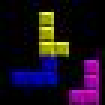

In [24]:
img = load(filenames[22])

In [25]:
function outputPad(x) 
    a, b, c, d = size(x)
#     hostx = Array{Float32}(x)
    paddedzeros = array_type(zeros(a+2, b+2, c, d))
    paddedzeros[2:a+1, 2:b+1, :, :] .= x
    return paddedzeros
end

struct DeConv1; w; b; f; p; pad; end
(c::DeConv1)(x) = c.f.(deconv4(c.w, dropout(x,c.p), padding=(c.pad,c.pad), stride=1) .+ c.b)
DeConv1(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0, pad=1) = DeConv1(param(w1,w2,cy,cx), param0(1,1,cy,1), f, pdrop, pad)

deconvlayer1 = DeConv1(5,5,slot_size,hidden_dim, pad=0)
deconvlayer2 = DeConv1(5,5,slot_size,hidden_dim, pad=0)
deconvlayer3 = DeConv1(5,5,slot_size,hidden_dim, pad=0)
deconvlayer4 = DeConv1(5,5,hidden_dim,4)

function example(x)
    # has dimention 2,2,32,256
    y = deconvlayer1(x)
    println(size(y))
    y = deconvlayer2(y)
    println(size(y))
    y = deconvlayer3(y)
    println(size(y))
    y = deconvlayer4(y)
    println(size(y))
end

out = example(param(2,2,32,256))

(6, 6, 32, 256)
(10, 10, 32, 256)
(14, 14, 32, 256)
(16, 16, 4, 256)


In [26]:
? RNN

search: RNN rnninit rnnforw rnnparam rnnparams randn randn! MersenneTwister



```
rnn = RNN(inputSize, hiddenSize; opts...)
rnn(x; batchSizes) => y
rnn.h, rnn.c  # hidden and cell states
```

`RNN` returns a callable RNN object `rnn`. Given a minibatch of sequences `x`, `rnn(x)` returns `y`, the hidden states of the final layer for each time step. `rnn.h` and `rnn.c` fields can be used to set the initial hidden states and read the final hidden states of all layers.  Note that the final time step of `y` always contains the final hidden state of the last layer, equivalent to `rnn.h` for a single layer network.

**Dimensions:** The input `x` can be 1, 2, or 3 dimensional and `y` will have the same number of dimensions as `x`. size(x)=(X,[B,T]) and size(y)=(H/2H,[B,T]) where X is inputSize, B is batchSize, T is seqLength, H is hiddenSize, 2H is for bidirectional RNNs. By default a 1-D `x` represents a single instance for a single time step, a 2-D `x` represents a single minibatch for a single time step, and a 3-D `x` represents a sequence of identically sized minibatches for multiple time steps. The output `y` gives the hidden state (of the final layer for multi-layer RNNs) for each time step. The fields `rnn.h` and `rnn.c` represent the hidden states of all layers in a single time step and have size (H,B,L/2L) where L is numLayers and 2L is for bidirectional RNNs.

**batchSizes:** If `batchSizes=nothing` (default), all sequences in a minibatch are assumed to be the same length. If `batchSizes` is an array of (non-increasing) integers, it gives us the batch size for each time step (allowing different sequences in the minibatch to have different lengths). In this case `x` will typically be 2-D with the second dimension representing variable size batches for time steps. If `batchSizes` is used, `sum(batchSizes)` should equal `length(x) ÷ size(x,1)`. When the batch size is different in every time step, hidden states will have size (H,B,L/2L) where B is always the size of the first (largest) minibatch.

**Hidden states:** The hidden and cell states are kept in `rnn.h` and `rnn.c` fields (the cell state is only used by LSTM). They can be initialized during construction using the `h` and `c` keyword arguments, or modified later by direct assignment. Valid values are `nothing` (default), `0`, or an array of the right type and size possibly wrapped in a `Param`. If the value is `nothing` the initial state is assumed to be zero and the final state is discarded keeping the value `nothing`. If the value is `0` the initial state is assumed to be zero and `0` is replaced by the final state on return. If the value is a valid state, it is used as the initial state and is replaced by the final state on return.

In a differentiation context the returned final hidden states will be wrapped in `Result` types. This is necessary if the same RNN object is to be called multiple times in a single iteration. Between iterations (i.e. after diff/update) the hidden states need to be unboxed with e.g. `rnn.h = value(rnn.h)` to prevent spurious dependencies. This happens automatically during the backward pass for GPU RNNs but needs to be done manually for CPU RNNs. See the [CharLM Tutorial](https://github.com/denizyuret/Knet.jl/blob/master/tutorial/80.charlm.ipynb) for an example.

**Keyword arguments for RNN:**

  * `h=nothing`: Initial hidden state.
  * `c=nothing`: Initial cell state.
  * `rnnType=:lstm` Type of RNN: One of :relu, :tanh, :lstm, :gru.
  * `numLayers=1`: Number of RNN layers.
  * `bidirectional=false`: Create a bidirectional RNN if `true`.
  * `dropout=0`: Dropout probability. Applied to input and between layers.
  * `skipInput=false`: Do not multiply the input with a matrix if `true`.
  * `algo=0`: Algorithm to use, see CUDNN docs for details.
  * `seed=0`: Random number seed for dropout. Uses `time()` if 0.
  * `winit=xavier`: Weight initialization method for matrices.
  * `binit=zeros`: Weight initialization method for bias vectors.
  * `finit=ones`: Weight initialization method for the bias of forget gates.
  * `atype=Knet.atype()`: array type for model weights.

**Formulas:** RNNs compute the output h[t] for a given iteration from the recurrent input h[t-1] and the previous layer input x[t] given matrices W, R and biases bW, bR from the following equations:

`:relu` and `:tanh`: Single gate RNN with activation function f:

```
h[t] = f(W * x[t] .+ R * h[t-1] .+ bW .+ bR)
```

`:gru`: Gated recurrent unit:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
r[t] = sigm(Wr * x[t] .+ Rr * h[t-1] .+ bWr .+ bRr) # reset gate
n[t] = tanh(Wn * x[t] .+ r[t] .* (Rn * h[t-1] .+ bRn) .+ bWn) # new gate
h[t] = (1 - i[t]) .* n[t] .+ i[t] .* h[t-1]
```

`:lstm`: Long short term memory unit with no peephole connections:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
f[t] = sigm(Wf * x[t] .+ Rf * h[t-1] .+ bWf .+ bRf) # forget gate
o[t] = sigm(Wo * x[t] .+ Ro * h[t-1] .+ bWo .+ bRo) # output gate
n[t] = tanh(Wn * x[t] .+ Rn * h[t-1] .+ bWn .+ bRn) # new gate
c[t] = f[t] .* c[t-1] .+ i[t] .* n[t]               # cell output
h[t] = o[t] .* tanh(c[t])
```
